In [16]:
%matplotlib notebook

In [17]:
import sys
sys.path.append('/usr/local/lib/python3/dist-packages')

In [18]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from ipywidgets import Checkbox, IntSlider, ToggleButtons, interactive
import matplotlib.pyplot as plt
from pywraps2 import S2Cell, S2LatLng, S2LatLngRect, S2RegionCoverer
from shapely.geometry import Polygon

In [19]:
class Plot:
    def __init__(self):
        self.fig = plt.figure(figsize=(4, 3), dpi=200)

        proj = cimgt.OSM()
        self.ax = plt.axes(projection=proj.crs)
        self.ax.add_image(proj, 17, interpolation='bilinear')
    
        # cartopy extent order is (x0, x1, y0, y1) or (lon0, lon1, lat0, lat1)
        self.ax.set_extent([-3.478665, -3.471724, 50.726045, 50.728911])
        
    def update(self, min_level, max_level, max_cells, cover_type=None, show_bbox=True):
        start = datetime.now()
        
        self.ax.artists = []
    
        # our bounding box of interest
        lat0, lon0 = 50.726771, -3.476471
        lat1, lon1 = 50.728089, -3.473832

        # shapely order is (x, y) or (lon, lat)
        bbox = Polygon([(lon0, lat0), (lon0, lat1),
                        (lon1, lat1), (lon1, lat0)])

        # s2 order is (y, x) or (lat, lon)
        region_rect = S2LatLngRect(
            S2LatLng.FromDegrees(lat0, lon0),
            S2LatLng.FromDegrees(lat1, lon1))

        coverer = S2RegionCoverer()
        coverer.set_min_level(min_level)
        coverer.set_max_level(max_level)
        coverer.set_max_cells(max_cells)
        region = region_rect.GetCapBound() if cover_type == "Cap" else region_rect
        covering = coverer.GetCovering(region)
        
        geoms = []
        for cellid in covering:
            new_cell = S2Cell(cellid)
            vertices = []
            for i in range(0, 4):
                vertex = new_cell.GetVertex(i)
                latlng = S2LatLng(vertex)
                # shapely vertex order is (x, y) or (lon, lat)
                vertices.append((latlng.lng().degrees(),
                                 latlng.lat().degrees()))
            geo = Polygon(vertices)
            geoms.append(geo)
            
        print("S2 geometries = {}".format(len(geoms)))

        pc = ccrs.PlateCarree()
        show_bbox = show_bbox.value if hasattr(show_bbox, "value") else show_bbox
        if show_bbox:
            self.ax.add_geometries([bbox], pc, facecolor=(0, 1, 0, 0.2), edgecolor=(0, 0, 0, 1), zorder=10)
        self.ax.add_geometries(geoms, pc, facecolor='coral', edgecolor='black', alpha=0.4, zorder=5)
    
        end = datetime.now()
    
        print("Update time   = {}s".format(end - start))
    
        plt.draw()

<IPython.core.display.Javascript object>


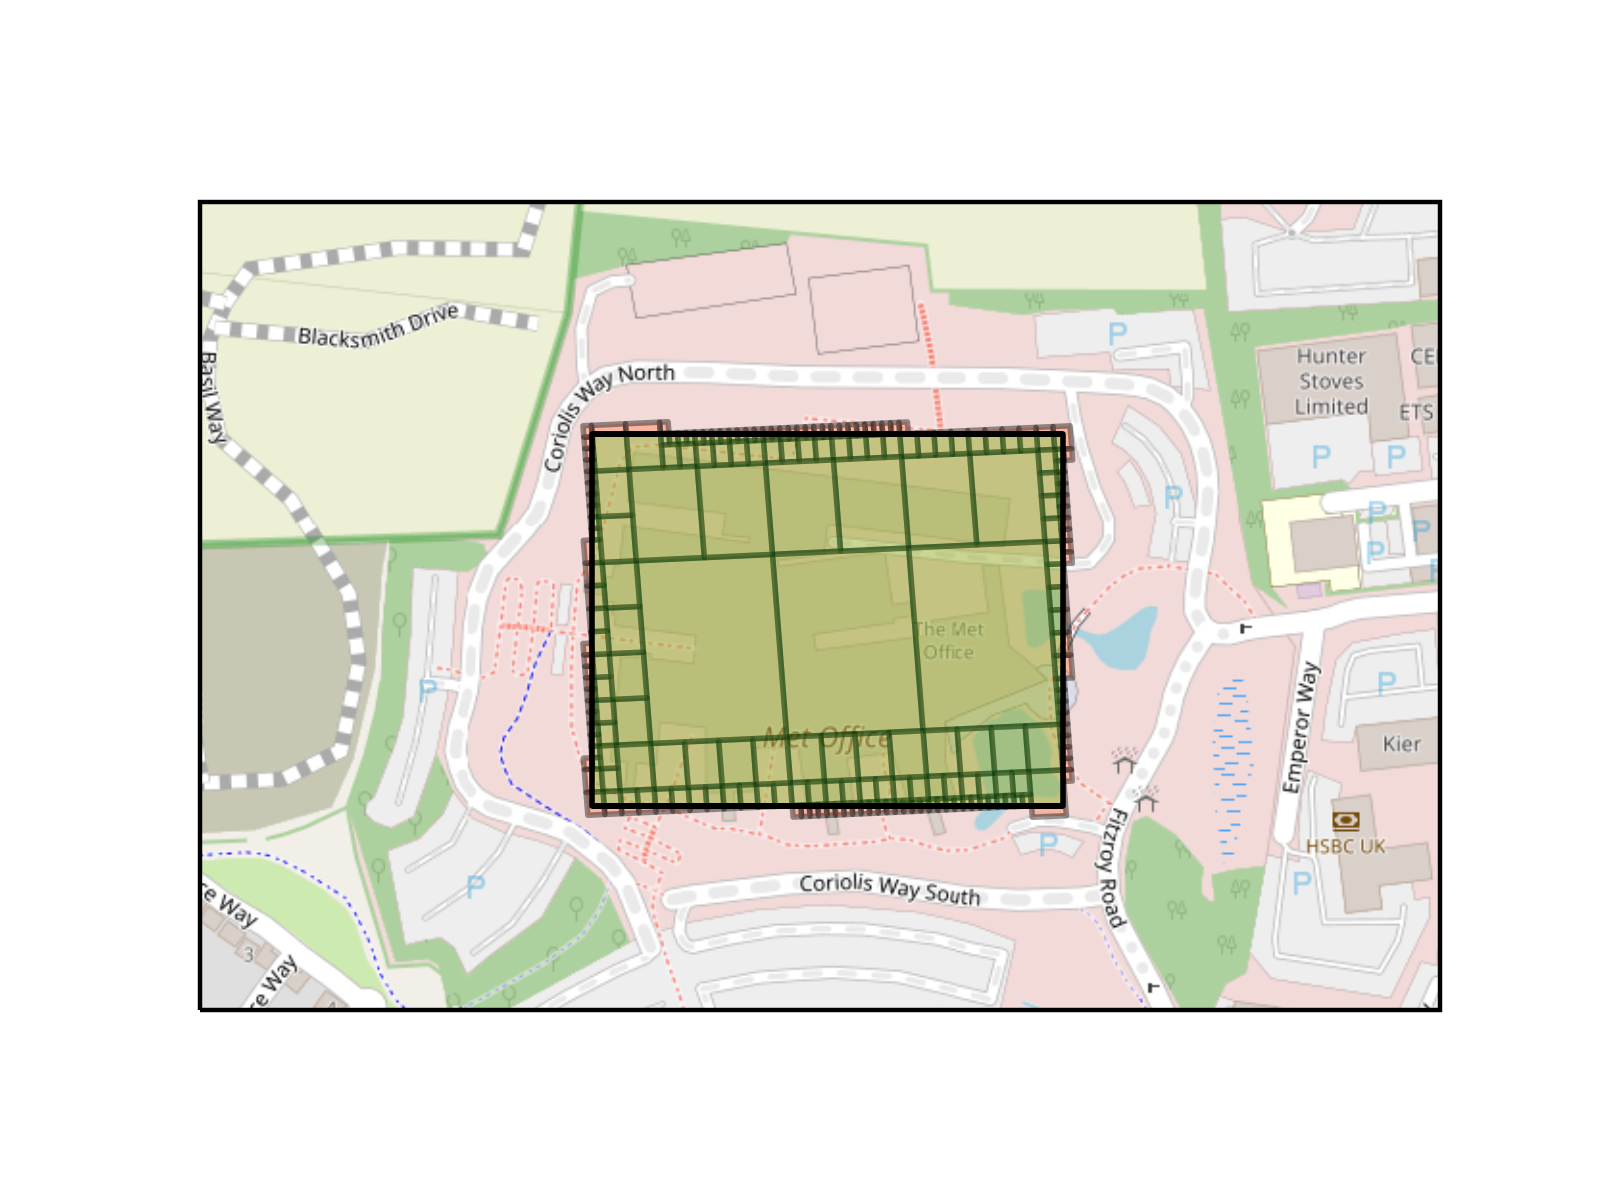

interactive(children=(IntSlider(value=4, continuous_update=False, description='min_level', max=30), IntSlider(…

In [20]:
def validate_min_level(*args):
    if min_level.value > max_level.value:
        min_level.value = args[0]['old']


def validate_max_level(*args):
    if max_level.value < min_level.value:
        max_level.value = args[0]['old']


min_level = IntSlider(min=0, max=30, step=1, value=4, continuous_update=False)
max_level = IntSlider(min=0, max=30, step=1, value=18, continuous_update=False)
max_cells = IntSlider(min=1, max=250, step=1, value=10, continuous_update=False)
bbox = Checkbox(value=True, description="Show bbox", disable=False, indent=False)
cover = ToggleButtons(
    options=['Cap', 'Rectangle'],
    description='Cover:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Cover region with a spherical cap', 'Cover region with a bounding box'],
    value="Rectangle"
)

min_level.observe(validate_min_level, "value")
max_level.observe(validate_max_level, "value")

plot = Plot()

interactive(plot.update, min_level=min_level, max_level=max_level,
            max_cells=max_cells, cover_type=cover, show_bbox=bbox)